In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Data Loading and Preparation

In [2]:
# Load data
PROJECT_ROOT = os.path.abspath("..")
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "fifa_players.csv")

df = pd.read_csv(DATA_PATH, low_memory=False)

# Define features and targets
target_overall = "overall_rating"
target_potential = "potential"

feature_cols = [
    "age", "height_cm", "weight_kgs",
    "finishing", "dribbling", "short_passing",
    "acceleration", "sprint_speed", "stamina", "strength"
]

# Clean data
df_clean = df.dropna(subset=feature_cols + [target_overall, target_potential]).copy()

# Prepare datasets
X = df_clean[feature_cols].copy()
y_overall = df_clean[target_overall].copy()

# Create future_class for classification
def build_future_label(row):
    gap = row[target_potential] - row[target_overall]
    age = row["age"]
    if gap >= 10 and age <= 23:
        return "high_growth"
    elif gap >= 4:
        return "likely_improve"
    elif gap >= -2:
        return "stable"
    else:
        return "decline"

df_clean["future_class"] = df_clean.apply(build_future_label, axis=1)
y_future = df_clean["future_class"].copy()

print(f"✓ Data loaded: {len(df_clean)} players")
print(f"✓ Features: {feature_cols}")
print(f"✓ Target (Regression): {target_overall}")
print(f"✓ Target (Classification): future_class")
print(f"\nClass Distribution:\n{y_future.value_counts()}")

✓ Data loaded: 17954 players
✓ Features: ['age', 'height_cm', 'weight_kgs', 'finishing', 'dribbling', 'short_passing', 'acceleration', 'sprint_speed', 'stamina', 'strength']
✓ Target (Regression): overall_rating
✓ Target (Classification): future_class

Class Distribution:
future_class
stable            8925
likely_improve    5014
high_growth       4015
Name: count, dtype: int64


## 2. Regression Models: Predicting Overall Rating

### 2.1 Train/Test Split

In [3]:
# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_overall, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Training set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")

✓ Training set: 14363 samples
✓ Test set: 3591 samples


### 2.2 Model Training - Linear Regression (Baseline)

In [4]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("=" * 50)
print("LINEAR REGRESSION (Baseline)")
print("=" * 50)
print(f"MSE:  {lr_mse:.4f}")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE:  {lr_mae:.4f}")
print(f"R²:   {lr_r2:.4f}")
print(f"CV R² (mean ± std): {lr_cv_scores.mean():.4f} ± {lr_cv_scores.std():.4f}")

LINEAR REGRESSION (Baseline)
MSE:  26.1215
RMSE: 5.1109
MAE:  3.9592
R²:   0.4773
CV R² (mean ± std): 0.4713 ± 0.0078


### 2.3 Model Training - Random Forest Regressor

In [5]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

print("=" * 50)
print("RANDOM FOREST REGRESSOR")
print("=" * 50)
print(f"MSE:  {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE:  {rf_mae:.4f}")
print(f"R²:   {rf_r2:.4f}")
print(f"CV R² (mean ± std): {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

RANDOM FOREST REGRESSOR
MSE:  10.4043
RMSE: 3.2256
MAE:  2.2700
R²:   0.7918
CV R² (mean ± std): 0.7827 ± 0.0056


### 2.4 Model Training - Gradient Boosting Regressor

In [6]:
# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

# Cross-validation
gb_cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='r2')

print("=" * 50)
print("GRADIENT BOOSTING REGRESSOR")
print("=" * 50)
print(f"MSE:  {gb_mse:.4f}")
print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE:  {gb_mae:.4f}")
print(f"R²:   {gb_r2:.4f}")
print(f"CV R² (mean ± std): {gb_cv_scores.mean():.4f} ± {gb_cv_scores.std():.4f}")

GRADIENT BOOSTING REGRESSOR
MSE:  10.0893
RMSE: 3.1764
MAE:  2.2514
R²:   0.7981
CV R² (mean ± std): 0.7872 ± 0.0062


### 2.5 Model Training - XGBoost Regressor

In [7]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

# Cross-validation
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

print("=" * 50)
print("XGBOOST REGRESSOR")
print("=" * 50)
print(f"MSE:  {xgb_mse:.4f}")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE:  {xgb_mae:.4f}")
print(f"R²:   {xgb_r2:.4f}")
print(f"CV R² (mean ± std): {xgb_cv_scores.mean():.4f} ± {xgb_cv_scores.std():.4f}")

XGBOOST REGRESSOR
MSE:  10.0479
RMSE: 3.1698
MAE:  2.2420
R²:   0.7989
CV R² (mean ± std): 0.7877 ± 0.0060


## 3. Regression Models Comparison

In [8]:
# Create comparison dataframe
regression_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'MSE': [lr_mse, rf_mse, gb_mse, xgb_mse],
    'RMSE': [lr_rmse, rf_rmse, gb_rmse, xgb_rmse],
    'MAE': [lr_mae, rf_mae, gb_mae, xgb_mae],
    'R² (Test)': [lr_r2, rf_r2, gb_r2, xgb_r2],
    'R² (CV Mean)': [lr_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean(), xgb_cv_scores.mean()]
})

print("\n" + "=" * 80)
print("REGRESSION MODELS COMPARISON - PREDICTING OVERALL RATING")
print("=" * 80)
print(regression_results.to_string(index=False))
print("=" * 80)

# Find best model
best_model_idx = regression_results['R² (Test)'].idxmax()
best_model_name = regression_results.loc[best_model_idx, 'Model']
best_r2 = regression_results.loc[best_model_idx, 'R² (Test)']

print(f"\n🏆 BEST REGRESSION MODEL: {best_model_name} (R² = {best_r2:.4f})")


REGRESSION MODELS COMPARISON - PREDICTING OVERALL RATING
            Model       MSE     RMSE      MAE  R² (Test)  R² (CV Mean)
Linear Regression 26.121458 5.110916 3.959229   0.477331      0.471319
    Random Forest 10.404251 3.225562 2.269994   0.791819      0.782704
Gradient Boosting 10.089349 3.176374 2.251427   0.798120      0.787158
          XGBoost 10.047936 3.169848 2.242003   0.798949      0.787701

🏆 BEST REGRESSION MODEL: XGBoost (R² = 0.7989)


### 3.1 Visualization: Model Comparison

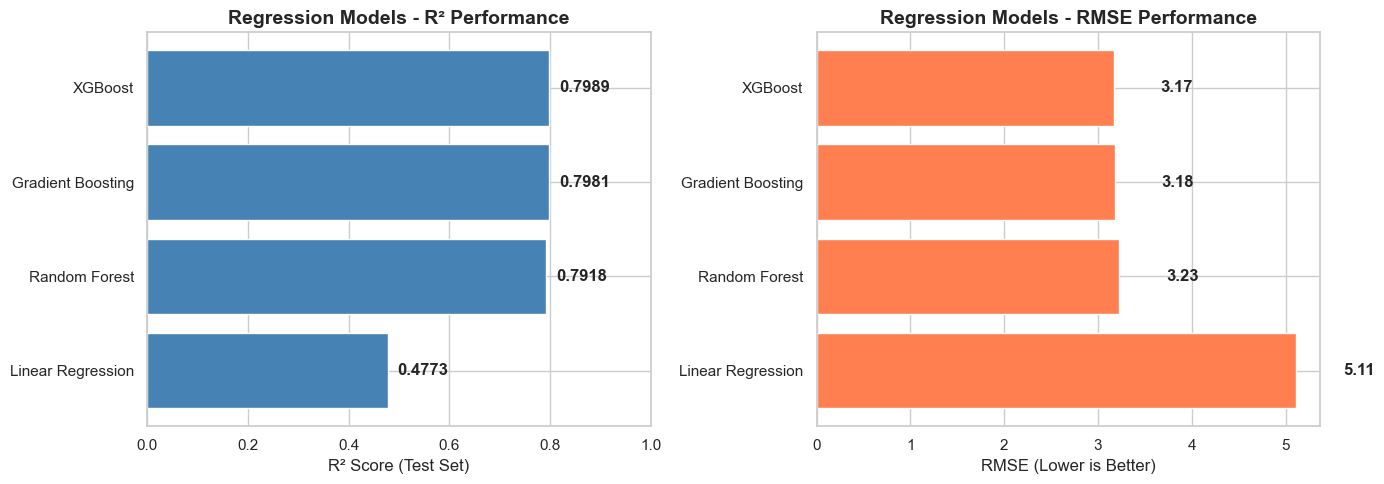

✓ Chart saved: regression_models_comparison.png


In [9]:
# Plot R² Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² Comparison
axes[0].barh(regression_results['Model'], regression_results['R² (Test)'], color='steelblue')
axes[0].set_xlabel('R² Score (Test Set)', fontsize=12)
axes[0].set_title('Regression Models - R² Performance', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(regression_results['R² (Test)']):
    axes[0].text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold')

# RMSE Comparison
axes[1].barh(regression_results['Model'], regression_results['RMSE'], color='coral')
axes[1].set_xlabel('RMSE (Lower is Better)', fontsize=12)
axes[1].set_title('Regression Models - RMSE Performance', fontsize=14, fontweight='bold')
for i, v in enumerate(regression_results['RMSE']):
    axes[1].text(v + 0.5, i, f'{v:.2f}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'src', 'regression_models_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: regression_models_comparison.png")

### 3.2 Feature Importance Analysis

In [10]:
# Feature Importance from ensemble models
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_gb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_xgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "=" * 50)
print("FEATURE IMPORTANCE - RANDOM FOREST")
print("=" * 50)
print(feature_importance_rf.to_string(index=False))

print("\n" + "=" * 50)
print("FEATURE IMPORTANCE - GRADIENT BOOSTING")
print("=" * 50)
print(feature_importance_gb.to_string(index=False))

print("\n" + "=" * 50)
print("FEATURE IMPORTANCE - XGBOOST")
print("=" * 50)
print(feature_importance_xgb.to_string(index=False))


FEATURE IMPORTANCE - RANDOM FOREST
      Feature  Importance
short_passing    0.436568
          age    0.169141
    dribbling    0.105847
     strength    0.078189
    finishing    0.066047
      stamina    0.044267
 sprint_speed    0.031531
 acceleration    0.027090
   weight_kgs    0.026181
    height_cm    0.015139

FEATURE IMPORTANCE - GRADIENT BOOSTING
      Feature  Importance
short_passing    0.495077
          age    0.178519
    dribbling    0.109270
     strength    0.078634
    finishing    0.064097
      stamina    0.030824
 sprint_speed    0.020337
   weight_kgs    0.009376
 acceleration    0.009029
    height_cm    0.004837

FEATURE IMPORTANCE - XGBOOST
      Feature  Importance
short_passing    0.436119
          age    0.202294
    dribbling    0.115493
     strength    0.091924
    finishing    0.041078
      stamina    0.033024
 sprint_speed    0.030453
   weight_kgs    0.019198
 acceleration    0.018097
    height_cm    0.012319


### 3.3 Visualization: Feature Importance Comparison

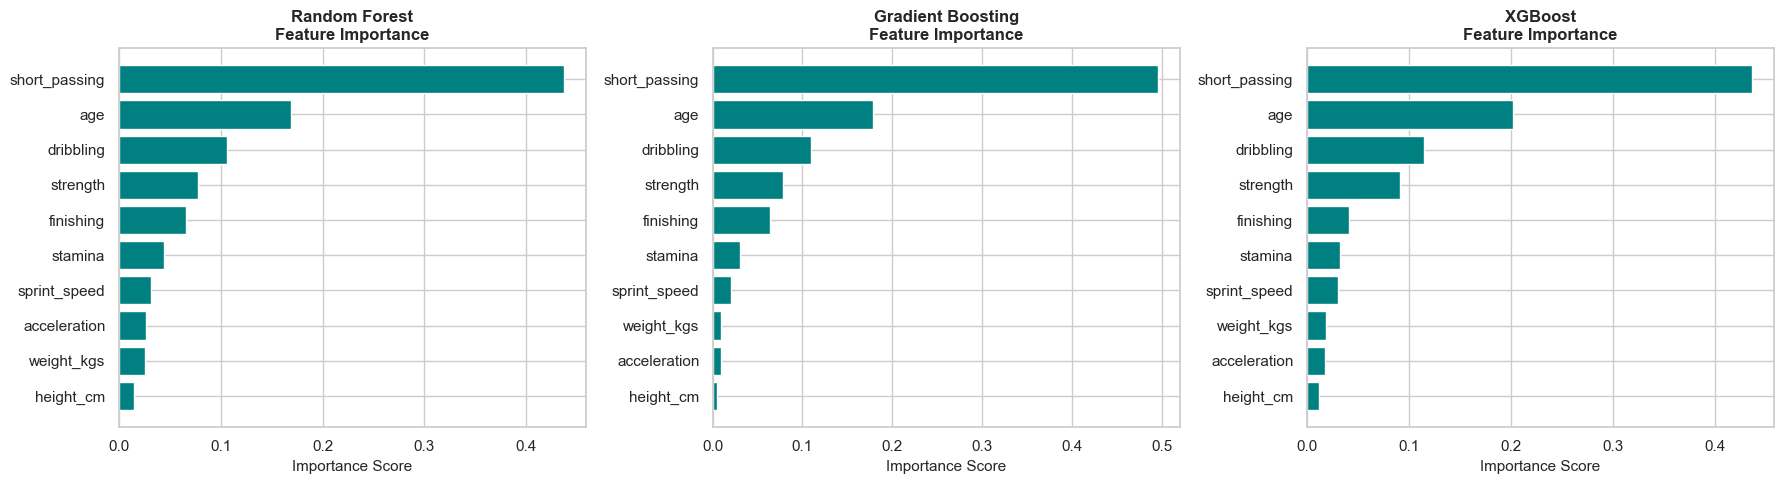

✓ Chart saved: feature_importance_comparison.png


In [11]:
# Feature Importance Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_importance = [
    (feature_importance_rf, 'Random Forest', axes[0]),
    (feature_importance_gb, 'Gradient Boosting', axes[1]),
    (feature_importance_xgb, 'XGBoost', axes[2])
]

for importance_df, model_name, ax in models_importance:
    ax.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
    ax.set_xlabel('Importance Score', fontsize=11)
    ax.set_title(f'{model_name}\nFeature Importance', fontsize=12, fontweight='bold')
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'src', 'feature_importance_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: feature_importance_comparison.png")

## 4. Classification Models: Predicting Future Development

### 4.1 Train/Test Split for Classification

In [12]:
# Stratified split for classification
from sklearn.preprocessing import LabelEncoder

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_future, test_size=0.2, random_state=42, stratify=y_future
)

print(f"✓ Classification Training set: {len(X_train_cls)} samples")
print(f"✓ Classification Test set: {len(X_test_cls)} samples")
print(f"\nClass Distribution (Train):\n{y_train_cls.value_counts()}")

✓ Classification Training set: 14363 samples
✓ Classification Test set: 3591 samples

Class Distribution (Train):
future_class
stable            7140
likely_improve    4011
high_growth       3212
Name: count, dtype: int64


### 4.2 Logistic Regression Classifier

In [13]:
# Logistic Regression (baseline)
lr_clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)
lr_clf.fit(X_train_cls, y_train_cls)
y_pred_lr_cls = lr_clf.predict(X_test_cls)

lr_cls_accuracy = accuracy_score(y_test_cls, y_pred_lr_cls)
lr_cls_cv = cross_val_score(lr_clf, X_train_cls, y_train_cls, cv=5, scoring='accuracy')

print("=" * 50)
print("LOGISTIC REGRESSION CLASSIFIER")
print("=" * 50)
print(f"Accuracy: {lr_cls_accuracy:.4f}")
print(f"CV Accuracy (mean ± std): {lr_cls_cv.mean():.4f} ± {lr_cls_cv.std():.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_lr_cls))

LOGISTIC REGRESSION CLASSIFIER
Accuracy: 0.8925
CV Accuracy (mean ± std): 0.8885 ± 0.0050

Classification Report:
                precision    recall  f1-score   support

   high_growth       0.85      0.85      0.85       803
likely_improve       0.81      0.80      0.81      1003
        stable       0.96      0.96      0.96      1785

      accuracy                           0.89      3591
     macro avg       0.87      0.87      0.87      3591
  weighted avg       0.89      0.89      0.89      3591



### 4.3 Random Forest Classifier

In [14]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_cls, y_train_cls)
y_pred_rf_cls = rf_clf.predict(X_test_cls)

rf_cls_accuracy = accuracy_score(y_test_cls, y_pred_rf_cls)
rf_cls_cv = cross_val_score(rf_clf, X_train_cls, y_train_cls, cv=5, scoring='accuracy')

print("=" * 50)
print("RANDOM FOREST CLASSIFIER")
print("=" * 50)
print(f"Accuracy: {rf_cls_accuracy:.4f}")
print(f"CV Accuracy (mean ± std): {rf_cls_cv.mean():.4f} ± {rf_cls_cv.std():.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_rf_cls))

RANDOM FOREST CLASSIFIER
Accuracy: 0.8892
CV Accuracy (mean ± std): 0.8858 ± 0.0039

Classification Report:
                precision    recall  f1-score   support

   high_growth       0.85      0.84      0.84       803
likely_improve       0.79      0.82      0.80      1003
        stable       0.97      0.95      0.96      1785

      accuracy                           0.89      3591
     macro avg       0.87      0.87      0.87      3591
  weighted avg       0.89      0.89      0.89      3591



### 4.4 Gradient Boosting Classifier

In [15]:
# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_clf.fit(X_train_cls, y_train_cls)
y_pred_gb_cls = gb_clf.predict(X_test_cls)

gb_cls_accuracy = accuracy_score(y_test_cls, y_pred_gb_cls)
gb_cls_cv = cross_val_score(gb_clf, X_train_cls, y_train_cls, cv=5, scoring='accuracy')

print("=" * 50)
print("GRADIENT BOOSTING CLASSIFIER")
print("=" * 50)
print(f"Accuracy: {gb_cls_accuracy:.4f}")
print(f"CV Accuracy (mean ± std): {gb_cls_cv.mean():.4f} ± {gb_cls_cv.std():.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_gb_cls))

GRADIENT BOOSTING CLASSIFIER
Accuracy: 0.8883
CV Accuracy (mean ± std): 0.8839 ± 0.0048

Classification Report:
                precision    recall  f1-score   support

   high_growth       0.85      0.84      0.84       803
likely_improve       0.79      0.81      0.80      1003
        stable       0.96      0.95      0.96      1785

      accuracy                           0.89      3591
     macro avg       0.87      0.87      0.87      3591
  weighted avg       0.89      0.89      0.89      3591



### 4.5 XGBoost Classifier

In [16]:
# XGBoost Classifier
# Encode target classes
le = LabelEncoder()
y_train_cls_encoded = le.fit_transform(y_train_cls)
y_test_cls_encoded = le.transform(y_test_cls)

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_clf.fit(X_train_cls, y_train_cls_encoded)
y_pred_xgb_cls = xgb_clf.predict(X_test_cls)

# Map back to original labels
y_pred_xgb_cls = le.inverse_transform(y_pred_xgb_cls)

xgb_cls_accuracy = accuracy_score(y_test_cls, y_pred_xgb_cls)
xgb_cls_cv = cross_val_score(xgb_clf, X_train_cls, y_train_cls_encoded, cv=5, scoring='accuracy')

print("=" * 50)
print("XGBOOST CLASSIFIER")
print("=" * 50)
print(f"Accuracy: {xgb_cls_accuracy:.4f}")
print(f"CV Accuracy (mean ± std): {xgb_cls_cv.mean():.4f} ± {xgb_cls_cv.std():.4f}")
print("\nClassification Report:")
print(classification_report(y_test_cls, y_pred_xgb_cls))

XGBOOST CLASSIFIER
Accuracy: 0.8925
CV Accuracy (mean ± std): 0.8877 ± 0.0038

Classification Report:
                precision    recall  f1-score   support

   high_growth       0.86      0.85      0.85       803
likely_improve       0.80      0.82      0.81      1003
        stable       0.96      0.95      0.96      1785

      accuracy                           0.89      3591
     macro avg       0.87      0.87      0.87      3591
  weighted avg       0.89      0.89      0.89      3591



## 5. Classification Models Comparison

In [17]:
# Create comparison dataframe
classification_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy (Test)': [lr_cls_accuracy, rf_cls_accuracy, gb_cls_accuracy, xgb_cls_accuracy],
    'CV Accuracy (Mean)': [lr_cls_cv.mean(), rf_cls_cv.mean(), gb_cls_cv.mean(), xgb_cls_cv.mean()],
    'CV Std': [lr_cls_cv.std(), rf_cls_cv.std(), gb_cls_cv.std(), xgb_cls_cv.std()]
})

print("\n" + "=" * 80)
print("CLASSIFICATION MODELS COMPARISON - PREDICTING FUTURE DEVELOPMENT")
print("=" * 80)
print(classification_results.to_string(index=False))
print("=" * 80)

# Find best model
best_cls_idx = classification_results['Accuracy (Test)'].idxmax()
best_cls_name = classification_results.loc[best_cls_idx, 'Model']
best_cls_acc = classification_results.loc[best_cls_idx, 'Accuracy (Test)']

print(f"\n🏆 BEST CLASSIFICATION MODEL: {best_cls_name} (Accuracy = {best_cls_acc:.4f})")


CLASSIFICATION MODELS COMPARISON - PREDICTING FUTURE DEVELOPMENT
              Model  Accuracy (Test)  CV Accuracy (Mean)   CV Std
Logistic Regression         0.892509            0.888463 0.004993
      Random Forest         0.889167            0.885817 0.003892
  Gradient Boosting         0.888332            0.883937 0.004776
            XGBoost         0.892509            0.887697 0.003828

🏆 BEST CLASSIFICATION MODEL: Logistic Regression (Accuracy = 0.8925)


### 5.1 Visualization: Classification Models Comparison

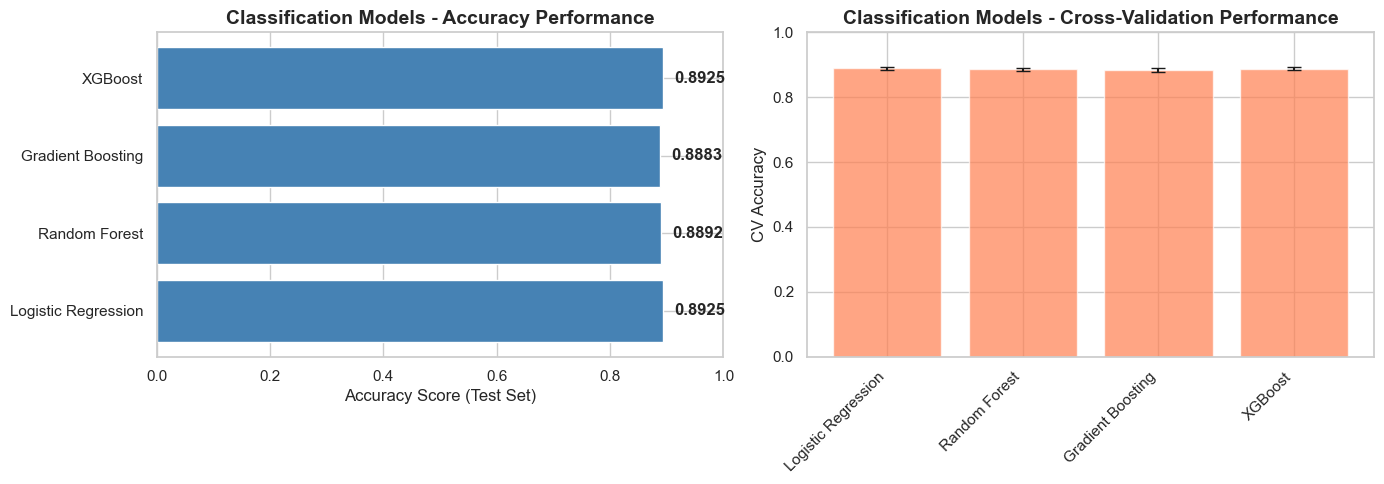

✓ Chart saved: classification_models_comparison.png


In [18]:
# Plot accuracy comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Comparison
axes[0].barh(classification_results['Model'], classification_results['Accuracy (Test)'], color='steelblue')
axes[0].set_xlabel('Accuracy Score (Test Set)', fontsize=12)
axes[0].set_title('Classification Models - Accuracy Performance', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(classification_results['Accuracy (Test)']):
    axes[0].text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold')

# CV Accuracy Comparison
axes[1].bar(range(len(classification_results)), classification_results['CV Accuracy (Mean)'], 
            yerr=classification_results['CV Std'], capsize=5, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(classification_results)))
axes[1].set_xticklabels(classification_results['Model'], rotation=45, ha='right')
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title('Classification Models - Cross-Validation Performance', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'src', 'classification_models_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved: classification_models_comparison.png")

## 6. Hyperparameter Tuning (Optional - Best Models)

In [19]:
# Hyperparameter tuning for the best regression model (let's use XGBoost)
print("🔧 Hyperparameter Tuning for XGBoost Regressor...")

param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150]
}

xgb_tuned = xgb.XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(xgb_tuned, param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"✓ Best parameters: {grid_search.best_params_}")
print(f"✓ Best CV R² Score: {grid_search.best_score_:.4f}")

# Evaluate tuned model
xgb_tuned_best = grid_search.best_estimator_
y_pred_xgb_tuned = xgb_tuned_best.predict(X_test)
xgb_tuned_r2 = r2_score(y_test, y_pred_xgb_tuned)
xgb_tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))

print(f"\nTuned XGBoost Performance:")
print(f"  R² (Test): {xgb_tuned_r2:.4f}")
print(f"  RMSE: {xgb_tuned_rmse:.4f}")

🔧 Hyperparameter Tuning for XGBoost Regressor...
✓ Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
✓ Best CV R² Score: 0.7897

Tuned XGBoost Performance:
  R² (Test): 0.7989
  RMSE: 3.1704


## 7. Summary & Key Insights

In [20]:
print("\n" + "=" * 80)
print("PHASE 1 SUMMARY - ADVANCED ML MODELS")
print("=" * 80)

print("\n📊 REGRESSION ANALYSIS (Predicting Overall Rating):")
print(f"  • Best Model: {best_model_name}")
print(f"  • R² Score: {best_r2:.4f}")
print(f"  • Most Important Features:")
if best_model_name == 'Random Forest':
    for idx, row in feature_importance_rf.head(3).iterrows():
        print(f"    - {row['Feature']}: {row['Importance']:.4f}")
elif best_model_name == 'XGBoost':
    for idx, row in feature_importance_xgb.head(3).iterrows():
        print(f"    - {row['Feature']}: {row['Importance']:.4f}")
else:
    for idx, row in feature_importance_gb.head(3).iterrows():
        print(f"    - {row['Feature']}: {row['Importance']:.4f}")

print("\n🎯 CLASSIFICATION ANALYSIS (Predicting Future Development):")
print(f"  • Best Model: {best_cls_name}")
print(f"  • Accuracy: {best_cls_acc:.4f}")
print(f"  • Classes Predicted:")
for cls in y_future.unique():
    count = (y_test_cls == cls).sum()
    print(f"    - {cls}: {count} players")

print("\n✅ Phase 1 Completed Successfully!")
print("=" * 80)


PHASE 1 SUMMARY - ADVANCED ML MODELS

📊 REGRESSION ANALYSIS (Predicting Overall Rating):
  • Best Model: XGBoost
  • R² Score: 0.7989
  • Most Important Features:
    - short_passing: 0.4361
    - age: 0.2023
    - dribbling: 0.1155

🎯 CLASSIFICATION ANALYSIS (Predicting Future Development):
  • Best Model: Logistic Regression
  • Accuracy: 0.8925
  • Classes Predicted:
    - stable: 1785 players
    - likely_improve: 1003 players
    - high_growth: 803 players

✅ Phase 1 Completed Successfully!
